# Imports

In [89]:
import pandas as pd
import sys
import numpy as np
import warnings
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte
import cv2

%matplotlib inline


# Constants

In [90]:
path = ''
folder = path + 'wikiart/'
real_train_df = pd.read_csv(folder + 'realism_train.csv')
impr_train_df = pd.read_csv(folder + 'impressionism_train.csv')



In [91]:
def read_image_and_resize(f, w = 100, h = 100):
    """
    Reads a JPEG image file, resizes it to the specified dimensions, 
    converts it to RGB format, and ensures it has the correct shape.

    Parameters:
    f (str): File path of the image to be read.
    w (int, optional): Width to which the image should be resized. Defaults to 100.
    h (int, optional): Height to which the image should be resized. Defaults to 100.

    Returns:
    np.ndarray: The processed image with shape (1, h, w, 3).

    Raises:
    ValueError: If the resulting image does not have the expected shape (1, h, w, 3).
    """
    if f.endswith('jpg'):
      img = cv2.imread(f)
      with warnings.catch_warnings():
          warnings.simplefilter('ignore')
          img = transform.resize(img, (w, h), mode='constant') 
          img = img_as_ubyte(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img[np.newaxis, :, :, :3]
      if img.shape != (1, 100, 100, 3):
          raise ValueError(f + str(img.shape))
    return img

In [92]:
def read_images_4d_array(files_list):
    """
    Reads a list of image files and returns a single 4D array containing all the images.

    Parameters:
    files_list (list): List of image file paths.

    Returns:
    np.ndarray: A 4D array containing all the processed images.
    """
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list, axis=0)
    return images_array

In [93]:
real_display_images = read_images_4d_array(real_display_files)
impr_display_images = read_images_4d_array(impr_display_files)




In [94]:
real_display_images.shape

(400, 100, 100, 3)

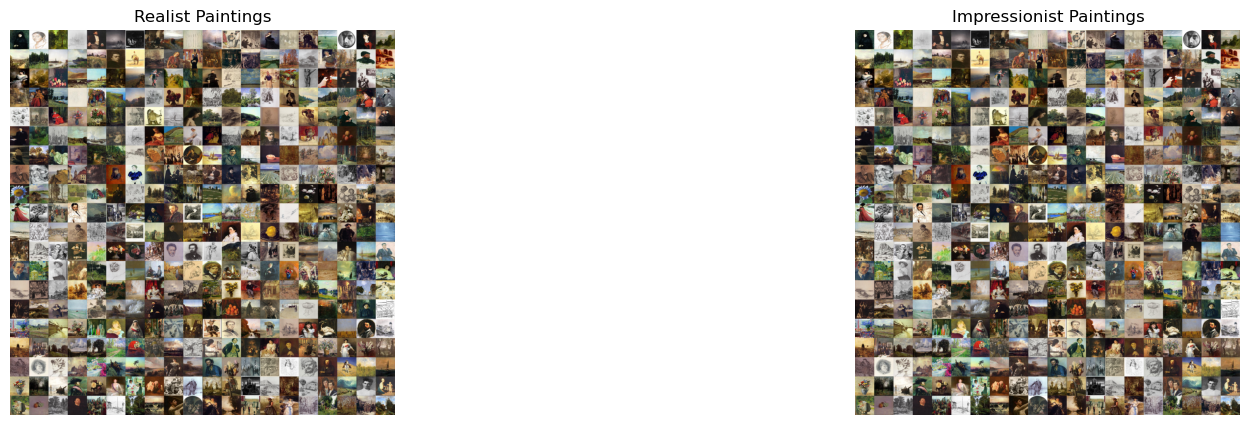

In [95]:
def merge_images(image_batch, size = [20, 20]):
    """
    Merge a batch of images into a single large image grid.
    
    Parameters:
    image_batch (numpy.ndarray): A 4D numpy array of shape (n, h, w, c) where n is the number of images, 
                                 h and w are the height and width of each image, and c is the number of color channels.
    size (list of int): A list of two integers [rows, cols] indicating the size of the grid. 
                        Defaults to [20, 20].
    
    Returns:
    numpy.ndarray: A 3D numpy array representing the merged image grid.
    """
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im/255.0 
    return img

real_merged = merge_images(image_batch=real_display_images)
impr_merged = merge_images(image_batch=impr_display_images)

fig, ax = plt.subplots(ncols = 2, figsize = (20,5))

ax[0].set_title('Realist Paintings')
ax[0].axis('off')
_ = ax[0].imshow(real_merged)

ax[1].set_title('Impressionist Paintings')
ax[1].axis('off')
_ = ax[1].imshow(real_merged)

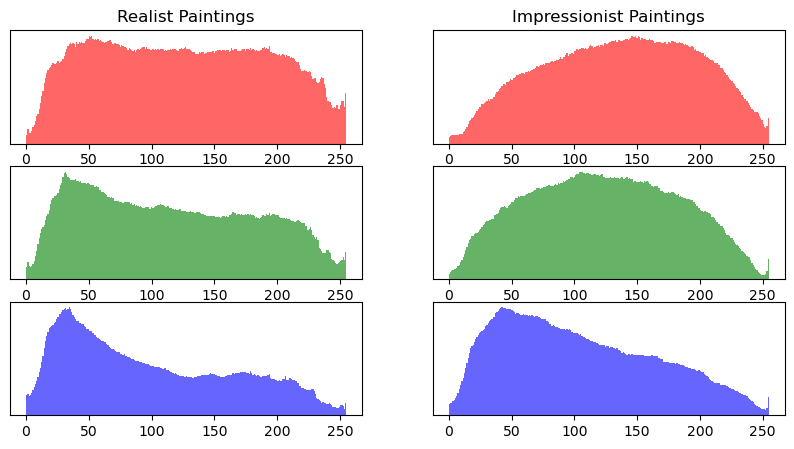

In [96]:
def plot_hist(images, channel, col):
    """
    Plot a histogram for a specific color channel of a batch of images.
    
    Parameters:
    images (numpy.ndarray): A 4D numpy array of shape (n, h, w, c) where n is the number of images,
                            h and w are the height and width of each image, and c is the number of color channels.
    channel (int): The index of the color channel to plot (0 for red, 1 for green, 2 for blue).
    col (str): The color of the histogram (e.g., 'red', 'green', 'blue').
    """
    vals = images[:, :, :, channel].flatten()
    plt.hist(vals, bins=256, color=col, alpha=0.6)
    plt.yticks([])


plt.figure(figsize =(10, 5))
plt.subplot(3, 2, 1)
plot_hist(real_display_images, 0, 'red')
plt.title('Realist Paintings')
plt.subplot(3, 2, 2)
plot_hist(impr_display_images, 0, 'red')
plt.title('Impressionist Paintings')
plt.subplot(3, 2, 3)
plot_hist(real_display_images, 1, 'green')
plt.subplot(3, 2, 4)
plot_hist(impr_display_images, 1, 'green')
plt.subplot(3, 2, 5)
plot_hist(real_display_images, 2, 'blue')
plt.subplot(3, 2, 6)
plot_hist(impr_display_images, 2, 'blue')
plt.show()

In [97]:
def summary(images, channel, col):
    """
    Print the summary statistics for a specific color channel of a batch of images.
    
    Parameters:
    images (numpy.ndarray): A 4D numpy array of shape (n, h, w, c) where n is the number of images,
                            h and w are the height and width of each image, and c is the number of color channels.
    channel (int): The index of the color channel to analyze (0 for red, 1 for green, 2 for blue).
    col (str): The color channel name (e.g., 'red', 'green', 'blue').
    """
    vals = images[:, :, :, channel].flatten()
    chan_mean = np.round(np.mean(vals), 3)
    chan_median = np.round(np.median(vals), 3)
    chan_share_above_220 = np.round(np.sum(vals > 220) / len(vals), 3)
    print('{} mean: {}, median: {}, share above 220: {}'.format(col, str(chan_mean), str(chan_median), str(chan_share_above_220)))

print('Realist:')
summary(real_display_images, 0, 'red')
summary(real_display_images, 1, 'green')
summary(real_display_images, 2, 'blue')
print('Impressionist:')
summary(impr_display_images, 0, 'red')
summary(impr_display_images, 1, 'green')
summary(impr_display_images, 2, 'blue')

Realist:
red mean: 125.029, median: 124.0, share above 220: 0.088
green mean: 114.997, median: 109.0, share above 220: 0.068
blue mean: 98.992, median: 84.0, share above 220: 0.044
Impressionist:
red mean: 136.156, median: 139.0, share above 220: 0.079
green mean: 123.239, median: 122.0, share above 220: 0.045
blue mean: 104.393, median: 95.0, share above 220: 0.039


In [98]:
def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

In [99]:
x_real_train, real_files_list = get_images_matrix(folder + 'realism_train.csv', folder + 'realism', 2000)
x_impr_train, impr_files_list = get_images_matrix(folder + 'impressionism_train.csv', folder + 'impressionism', 2000)

print(x_real_train.shape)
print(x_impr_train.shape)
print(*real_files_list[:5], sep='\n')

(2000, 100, 100, 3)
(2000, 100, 100, 3)
wikiart/realism/ilya-repin_nun-1878.jpg
wikiart/realism/david-burliuk_marusia-portrait-of-the-artist-s-wife-1928.jpg
wikiart/realism/nikolai-ge_florence-the-cascina-park.jpg
wikiart/realism/arkhip-kuindzhi_view-of-moscow.jpg
wikiart/realism/ilya-repin_portrait-of-sculptor-mark-matveevich-antokolski-1914.jpg


In [100]:
## trying to reduce the demensions for pca and further visualisation

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

x_real_train_all = get_all_pixels(x_real_train)
x_impr_train_all = get_all_pixels(x_impr_train)

print(x_real_train_all.shape)
print(x_impr_train_all.shape)

(2000, 30000)
(2000, 30000)


In [101]:
x_train = np.concatenate([x_real_train_all, x_impr_train_all], axis=0 )
x_train_centered = x_train - x_train.mean(axis = 0)

from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

pca.fit(x_train_centered)
W = pca.components_.T

x_train_reduced = np.matmul(x_train_centered, W)

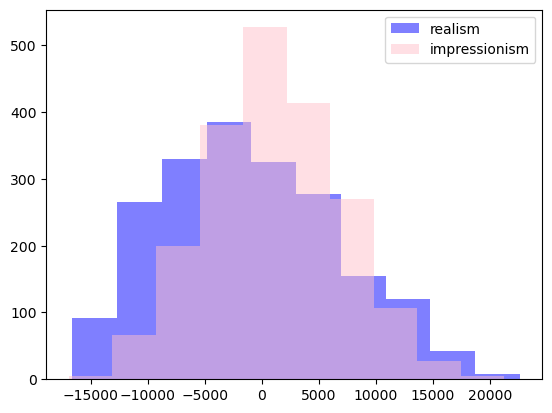

In [102]:
plt.hist(x_train_reduced[:2000, 0], alpha=0.5, label='realism', color = 'blue')
plt.hist(x_train_reduced[2000:, 0], alpha=0.5, label='impressionism', color = 'pink')
plt.legend(loc='upper right')
plt.show()

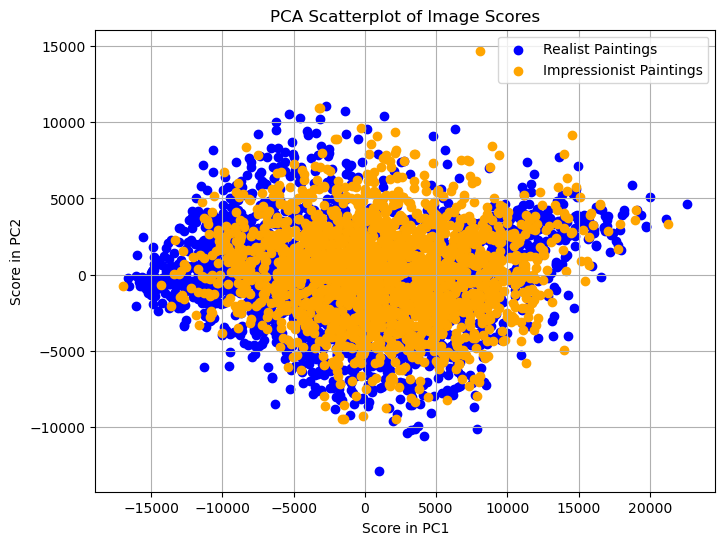

In [103]:
realist_scores = x_train_reduced[:2000]
impressionist_scores = x_train_reduced[2000:]

# Plot the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(realist_scores[:, 0], realist_scores[:, 1], color='blue', label='Realist Paintings')
plt.scatter(impressionist_scores[:, 0], impressionist_scores[:, 1], color='orange', label='Impressionist Paintings')
plt.xlabel('Score in PC1')
plt.ylabel('Score in PC2')
plt.title('PCA Scatterplot of Image Scores')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
highest_score_ids = np.argpartition(x_train_reduced[:, 0], -16)[-16:]
lowest_score_ids = np.argpartition(x_train_reduced[:, 0], 16)[:16]

all_files_list = np.array(real_files_list + impr_files_list)
highest_score_files = all_files_list[highest_score_ids]
lowest_score_files = all_files_list[lowest_score_ids]


In [105]:
highest_images = read_images_4d_array(highest_score_files)
lowest_images = read_images_4d_array(lowest_score_files)

highest_images_merged = merge_images(highest_images, size = [4, 4])
lowest_images_merged = merge_images(lowest_images, size = [4, 4])

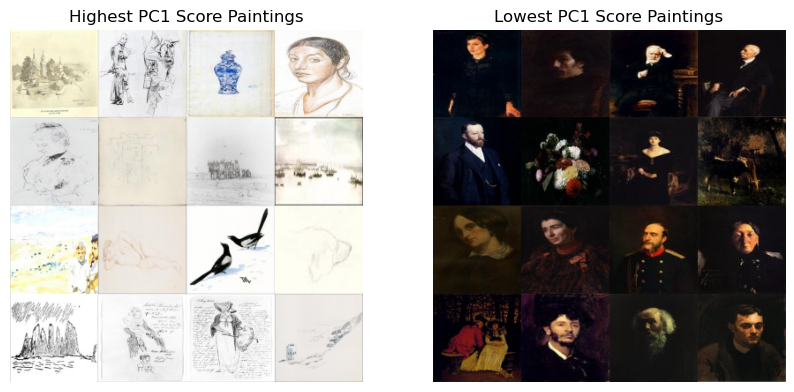

In [106]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC1 Score Paintings')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC1 Score Paintings')
plt.axis('off')
plt.imshow(lowest_images_merged)

plt.show()